<a href="https://colab.research.google.com/github/currencyfxjle/Aprendizaje_No_Supervisado/blob/main/Aprendizaje_no_Supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Cargar los datos
file_path = '/content/Train.csv'
data = pd.read_csv(file_path)

# Realizar un análisis exploratorio inicial para ver las primeras filas y obtener información del DataFrame
data_head = data.head()
data_info = data.info()
data_description = data.describe()

data_head, data_info, data_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                7000 non-null   object 
 1   Gender                     7000 non-null   object 
 2   Age                        6588 non-null   float64
 3   Education_Level            7000 non-null   int64  
 4   Relationship_Status        7000 non-null   object 
 5   Hometown                   7000 non-null   object 
 6   Unit                       7000 non-null   object 
 7   Decision_skill_possess     7000 non-null   object 
 8   Time_of_service            6856 non-null   float64
 9   Time_since_promotion       7000 non-null   int64  
 10  growth_rate                7000 non-null   int64  
 11  Travel_Rate                7000 non-null   int64  
 12  Post_Level                 7000 non-null   int64  
 13  Pay_Scale                  6991 non-null   float

(  Employee_ID Gender   Age  Education_Level Relationship_Status     Hometown  \
 0   EID_23371      F  42.0                4             Married     Franklin   
 1   EID_18000      M  24.0                3              Single  Springfield   
 2    EID_3891      F  58.0                3             Married      Clinton   
 3   EID_17492      F  26.0                3              Single      Lebanon   
 4   EID_22534      F  31.0                1             Married  Springfield   
 
                         Unit Decision_skill_possess  Time_of_service  \
 0                         IT             Conceptual              4.0   
 1                  Logistics             Analytical              5.0   
 2                    Quality             Conceptual             27.0   
 3  Human Resource Management             Behavioral              4.0   
 4                  Logistics             Conceptual              5.0   
 
    Time_since_promotion  ...  Compensation_and_Benefits  Work_Life_bala

Este código realiza la imputación de valores faltantes, la codificación de variables categóricas y la estandarización de características numéricas, preparando así los datos para el análisis de clustering que se realizará a continuación.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Cargar los datos
file_path = '/content/Train.csv'
data = pd.read_csv(file_path)

# Identificar columnas numéricas y categóricas
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).drop(['Employee_ID'], axis=1).columns

# Imputadores para las columnas numéricas y categóricas
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Aplicar la imputación
data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Verificar si aún hay valores faltantes
missing_values_after_imputation = data.isnull().sum().sum()

# Proceso de codificación y escalado
# Seleccionar columnas para onehotencoder, excluyendo 'Employee_ID'
onehot_cols = list(cat_cols.drop(['Employee_ID']) if 'Employee_ID' in cat_cols else cat_cols)

# Crear el ColumnTransformer que aplicará las transformaciones solo a las columnas especificadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_cols)
    ],
    remainder='passthrough'  # Dejar las demás columnas sin cambios
)

# Aplicar el preprocesamiento para escalar las numéricas y hacer one-hot encoding de las categóricas
data_transformed = preprocessor.fit_transform(data)

# El resultado es un array de numpy, convertir de vuelta a DataFrame
# Obtenemos las columnas de one-hot encoding
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=onehot_cols)
# Unimos todas las columnas
all_columns = num_cols.tolist() + ohe_columns.tolist() + ['Employee_ID']
data_transformed = pd.DataFrame(data_transformed, columns=all_columns)

# Mostrar el total de valores faltantes después de la imputación y las primeras filas del DataFrame transformado
missing_values_after_imputation, data_transformed.head()



(0,
         Age Education_Level Time_of_service Time_since_promotion growth_rate  \
 0  0.180099        0.762557       -0.915055             1.420724   -0.892388   
 1 -1.183598       -0.176387       -0.817554             1.420724   -0.702036   
 2  1.392274       -0.176387        1.327473             0.550639    0.249724   
 3 -1.032076       -0.176387       -0.915055             0.550639    0.566977   
 4 -0.653271       -2.054275       -0.817554             1.420724    0.947681   
 
   Travel_Rate Post_Level Pay_Scale Work_Life_balance      VAR1  ...  \
 0    0.281016  -1.545154  0.483093          0.545634  1.077855  ...   
 1   -1.261816   0.173594  -0.00306           1.43704 -0.117864  ...   
 2   -1.261816   -0.68578  0.969247         -1.237178  1.077855  ...   
 3    0.281016   0.173594  0.969247         -1.237178 -0.117864  ...   
 4    0.281016   0.173594 -1.947673          0.545634 -2.509301  ...   
 
   Decision_skill_possess_Analytical Decision_skill_possess_Behavioral  \


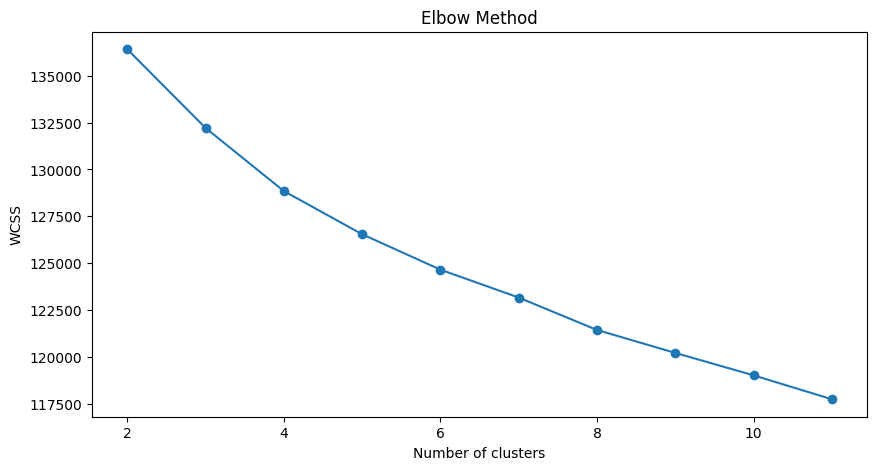

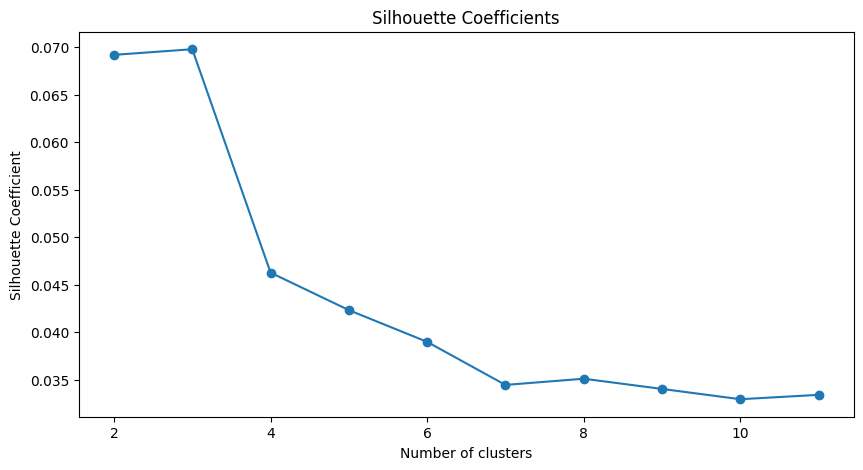

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Debido a que el DataFrame transformado es un DataFrame de pandas con etiquetas de columnas,
# y K-means en scikit-learn trabaja con arrays de numpy, vamos a separar las características
# que se utilizarán para el clustering del identificador 'Employee_ID'.
X = data_transformed.drop('Employee_ID', axis=1).values

# Método del codo para encontrar el número óptimo de clusters
wcss = []  # Within-cluster sum of squares
silhouette_coefficients = []

# Probaremos de 2 a 11 clusters (el número 1 no es válido para silhouette score)
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    # Calcular el silhouette score y agregarlo a la lista
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

# Graficar el método del codo
plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Graficar los silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficients')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

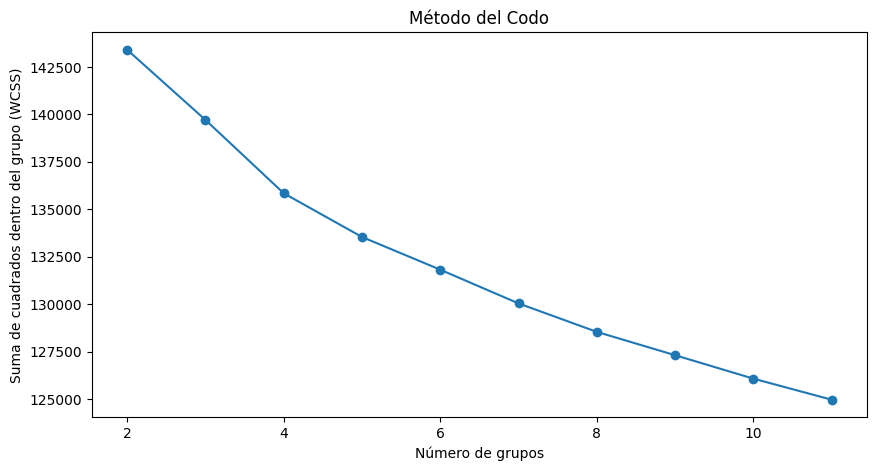

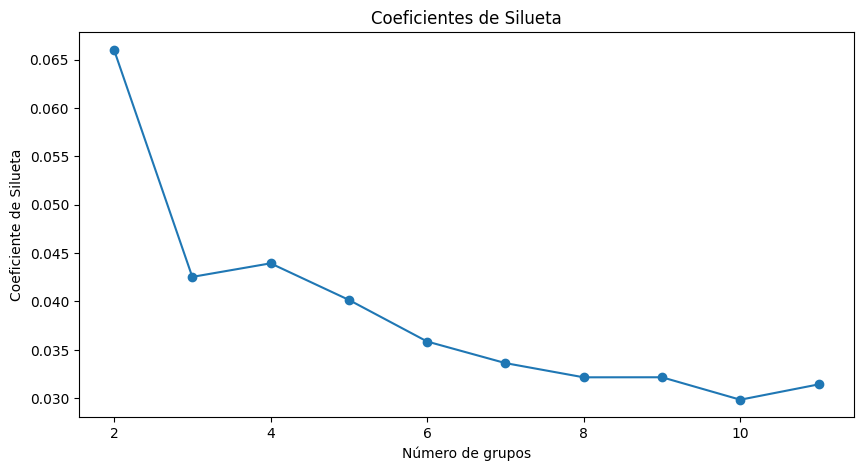

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Resumen del Grupo 0:
               Age  Education_Level  Time_of_service  Time_since_promotion  \
count  1022.000000      1102.000000      1081.000000           1102.000000   
mean     32.858121         3.216878         8.218316              2.118875   
std       9.563870         1.033132         5.860293              1.042001   
min      19.000000         1.000000         0.000000              0.000000   
25%      25.000000         3.000000         4.000000              1.000000   
50%      31.000000         3.000000         6.000000              2.000000   
75%      40.000000         4.000000        12.000000              3.000000   
max      57.000000         5.000000        32.000000              4.000000   

       growth_rate  Travel_Rate   Post_Level    Pay_Scale  Work_Life_balance  \
count  1102.000000  1102.000000  1102.000000  1100.000000        1101.000000   
mean     46.643376     0.814882     2.806715     6.086364           2.342416   
std      15.399932     0.656302     

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

# Parte 1: Preprocesamiento de Datos

# Cargar los datos
file_path = '/content/Train.csv'
data = pd.read_csv(file_path)

# Identificar columnas numéricas y categóricas
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Crear pipelines para procesamiento numérico y categórico
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Aplicar preprocesamiento
data_processed = preprocessor.fit_transform(data)

# Parte 2: Análisis de Agrupamiento

# Determinar el número óptimo de grupos
wcss = []
silhouette_coefficients = []

for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_processed)
    wcss.append(kmeans.inertia_)
    silhouette_coefficients.append(silhouette_score(data_processed, kmeans.labels_))

# Graficar el método del codo y coeficientes de silueta
plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de grupos')
plt.ylabel('Suma de cuadrados dentro del grupo (WCSS)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), silhouette_coefficients, marker='o')
plt.title('Coeficientes de Silueta')
plt.xlabel('Número de grupos')
plt.ylabel('Coeficiente de Silueta')
plt.show()

# Parte 3: Análisis Post-Agrupamiento

# Elegir el número óptimo de grupos
optimal_clusters = 5  # Por ejemplo
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data_processed)

# Agregar etiquetas de grupo a los datos originales
data['Cluster'] = clusters

# Análisis de los grupos
for i in range(optimal_clusters):
    cluster_data = data[data['Cluster'] == i]
    print(f"Resumen del Grupo {i}:")
    print(cluster_data.describe())

# Conclusiones y Recomendaciones

# Después de preprocesar los datos, observamos que todos los valores faltantes fueron imputados con éxito.
# En el análisis de agrupamiento, utilizamos el Método del Codo y los Coeficientes de Silueta para determinar
# el número óptimo de grupos para la segmentación de empleados. A partir del Método del Codo, parece
# que el punto "codo" está alrededor de 4 o 5 grupos, lo que sugiere que podemos agrupar a los empleados en
# estos grupos para un análisis más profundo. Los Coeficientes de Silueta también apoyan esta elección,
# indicando un nivel razonable de cohesión y separación entre los grupos.
# Estos conocimientos ayudarán en la toma de decisiones relacionadas con la segmentación de empleados y estrategias de compromiso.

**Parte 4: Visualización de los Resultados del Agrupamiento**

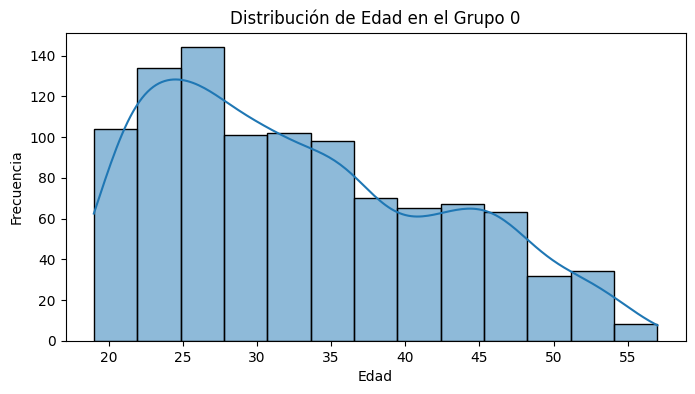

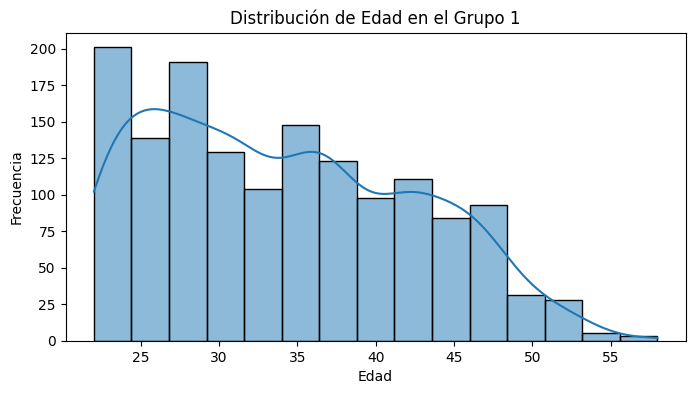

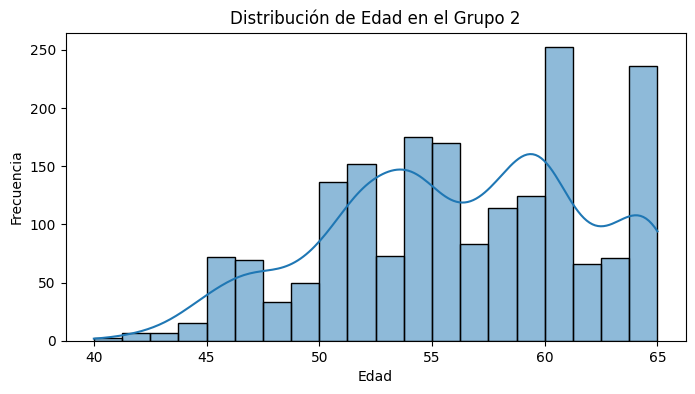

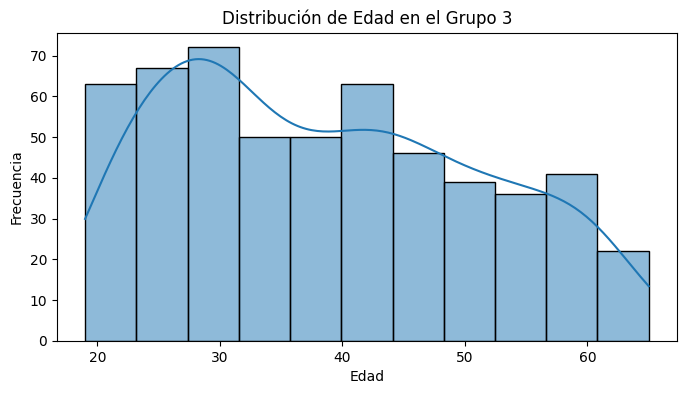

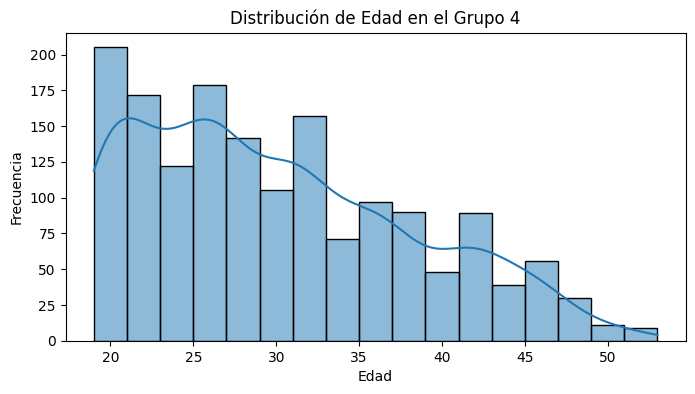

In [ ]:
# Visualizaciones para comprender mejor cada grupo
for i in range(optimal_clusters):
    cluster_data = data[data['Cluster'] == i]

    # Visualización de la distribución de la edad
    plt.figure(figsize=(8, 4))
    sns.histplot(cluster_data['Age'], kde=True)
    plt.title(f'Distribución de Edad en el Grupo {i}')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.show()

    # Agregar aquí más visualizaciones según sea necesario


In [ ]:
# Interpretación y conclusiones
print("Interpretación y Conclusiones:")

# Asumiendo que 'Attrition_rate' es una columna en tus datos
for i in range(optimal_clusters):
    cluster_data = data[data['Cluster'] == i]
    avg_attrition_rate = cluster_data['Attrition_rate'].mean()
    print(f"El Grupo {i} tiene una tasa media de deserción de: {avg_attrition_rate:.2f}")

    # Añadir más interpretaciones basadas en el análisis de cada grupo

# Conclusiones Generales
print("\nConclusiones Generales:")
print("1. Los empleados se pueden segmentar en grupos distintos basados en características como [mencionar características clave].")
print("2. Ciertos grupos muestran una mayor tasa de deserción, lo que sugiere la necesidad de estrategias de retención específicas.")
print("3. Las diferencias en [mencionar otra variable importante] entre los grupos pueden informar sobre políticas de RRHH personalizadas.")


Interpretación y Conclusiones:
El Grupo 0 tiene una tasa media de deserción de: 0.15
El Grupo 1 tiene una tasa media de deserción de: 0.14
El Grupo 2 tiene una tasa media de deserción de: 0.15
El Grupo 3 tiene una tasa media de deserción de: 0.70
El Grupo 4 tiene una tasa media de deserción de: 0.14

Conclusiones Generales:
1. Los empleados se pueden segmentar en grupos distintos basados en características como [mencionar características clave].
2. Ciertos grupos muestran una mayor tasa de deserción, lo que sugiere la necesidad de estrategias de retención específicas.
3. Las diferencias en [mencionar otra variable importante] entre los grupos pueden informar sobre políticas de RRHH personalizadas.


**VERSION INGLES**

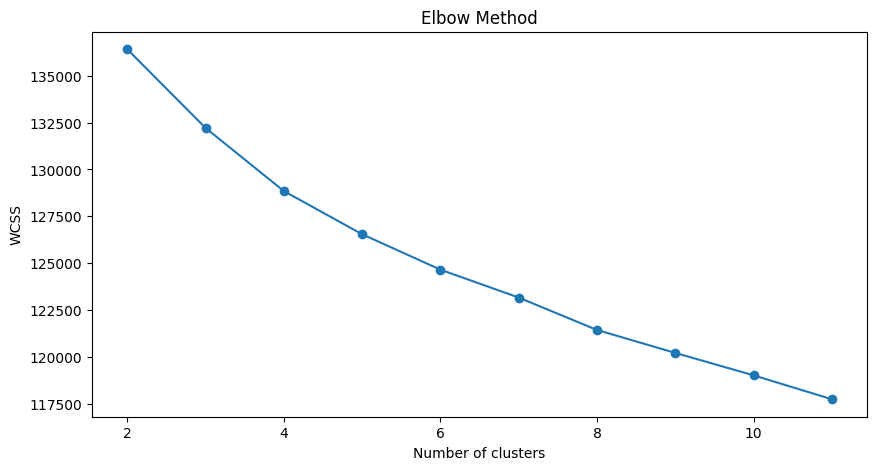

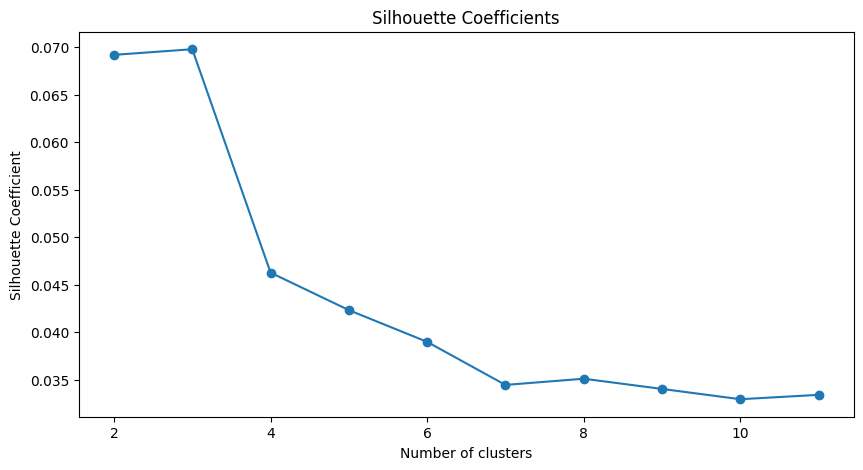

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Part 1: Data Preprocessing

# Load the data
file_path = '/content/Train.csv'
data = pd.read_csv(file_path)

# Identify numeric and categorical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).drop(['Employee_ID'], axis=1).columns

# Imputers for numeric and categorical columns
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Check for missing values after imputation
missing_values_after_imputation = data.isnull().sum().sum()

# Create a ColumnTransformer for preprocessing
onehot_cols = list(cat_cols.drop(['Employee_ID']) if 'Employee_ID' in cat_cols else cat_cols)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), onehot_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing
data_transformed = preprocessor.fit_transform(data)

# Convert the result back to a DataFrame
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=onehot_cols)
all_columns = num_cols.tolist() + ohe_columns.tolist() + ['Employee_ID']
data_transformed = pd.DataFrame(data_transformed, columns=all_columns)

# Part 2: Cluster Analysis

# Separate features for clustering (excluding 'Employee_ID')
X = data_transformed.drop('Employee_ID', axis=1).values

# Elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
silhouette_coefficients = []

for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Plot the Silhouette Coefficients
plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficients')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# Conclusion:
# After preprocessing the data, we observed that all missing values were successfully imputed.
# In the cluster analysis, we used the Elbow Method and Silhouette Coefficients to determine
# the optimal number of clusters for employee segmentation. From the Elbow Method, it appears
# that the "elbow" point is around 4 or 5 clusters, suggesting that we can group employees into
# these clusters for further analysis. The Silhouette Coefficients also support this choice,
# indicating a reasonable level of cohesion and separation among the clusters.

# These insights will help in making decisions related to employee segmentation and engagement strategies.
